# A Steam reviews classifier using Naive Bayes

<div style="text-align: justify">
Steam is a digital platform for the purchase of video games online. It is run by video game developer Valve.

Steam is one of the main options for purchasing video games online and has millions of active users every month.

One of the most important features of Steam is its review system. This system helps the user to decide whether to buy a game or not based on the experiences and recommendations of buyers of the game.

The review system classifies reviews as positive or negative, and cumulative reviews are classified as overhwelmingly positive, very positive, mostly positive, positive, mixed, overhwelmingly negative, very negative, mostly negative and negative.

</div>

This notebook presents step by step how to build a review classifier system using the **Naïve Bayes algorithm**.

# Importing the data
The data to train the model were obtained from the "Steam Reviews" (Sobkowicz A., 2017) dataset available in Kaggle.

In [1]:
import pandas as pd

steam_reviews = pd.read_csv('/kaggle/input/steam-reviews/dataset.csv') 

In [2]:
steam_reviews.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


# Exploratory data analysis

Once, we have imported the dataset is time to analyze the features and their content starting from the features names.

In [3]:
list(steam_reviews.columns)

['app_id', 'app_name', 'review_text', 'review_score', 'review_votes']

- app_id: Game ID.
- app_name: Game name.
- review_text: Text of the review.
- review_score: Whether the review recommends the game or not.
- review_votes: Whether the review was recommended by another user or not.

Number of dataset rows

In [4]:
rows = len(steam_reviews.index)
rows

6417106

Possible values of column "review_score".

In [5]:
list(pd.unique(steam_reviews['review_score']))

[1, -1]

We can see the positive reviews are recorded with a value of 1 and negative reviews are recorded with a value of -1.

Let's explore the number of games.

In [6]:
games = pd.unique(steam_reviews['app_name'])
games_count = len(games)
games_count

9364

In [7]:
import numpy as np

np.random.seed(2810)
sample_size = 150000

sample_id = np.random.randint(0, rows, sample_size)

sample_data = steam_reviews.loc[sample_id, ['review_text', 'review_score']]

### Positive reviews number vs Negative reviews number

Let's explore the number of positive and negative reviews in subset.

In [8]:
vc = sample_data['review_score'].value_counts().reset_index(name='count')
vcn = sample_data['review_score'].value_counts(normalize=True).reset_index(name='proportion')

review_score_stats = pd.merge(vc, vcn, on='index')
review_score_stats.rename(columns={'index': 'review_score'}, inplace=True)
review_score_stats

,review_score,count,proportion
0,1,122953,0.819687
1,-1,27047,0.180313


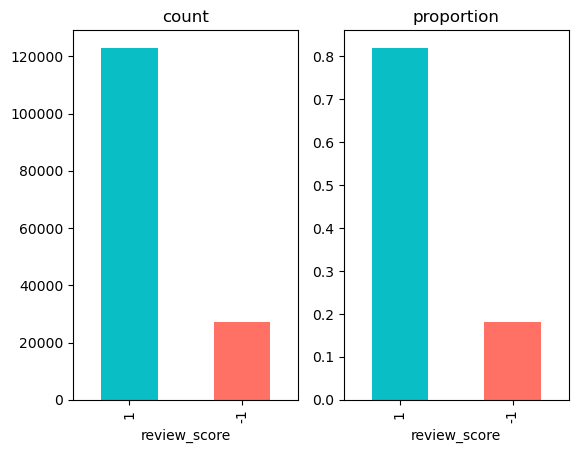

In [9]:
import matplotlib.pyplot as plt

kind = 'bar'
bar_color = ["#09BEC5", "#FF7065"]

fig, axes = plt.subplots(nrows=1,ncols=2)

review_score_stats.plot(x='review_score', 
                        y='count', 
                        ax = axes[0], 
                        kind=kind, 
                        color=bar_color, 
                        subplots=True,
                        legend=False)

review_score_stats.plot(x='review_score', 
                        y='proportion', 
                        ax = axes[1], 
                        kind=kind, 
                        color=bar_color, 
                        subplots=True, 
                        legend=False)

plt.show()

We can see that there are many more positive reviews than negative ones.

### Common reviews

Let's analyze the information for repeated reviews.

In [10]:
# Lowercase review text
reviews_text = sample_data['review_text'].reset_index(name='text')

# Count occurrences of review text
tc = reviews_text['text'].value_counts().reset_index(name='count')
tc.rename(columns={'index': 'text'}, inplace=True)
tc.head(10)

,text,count
0,Early Access Review,23463
1,Early Access Review,266
2,10/10,127
3,.,106
4,great game,91
5,Great game,91
6,:),56
7,Great game!,53
8,Great game.,49
9,♥♥♥♥,43


As shown in the table, the text "early access review" is repeated too much, this text does not add information to the model, so it will be removed later.

# Preparing the data

<div style="text-align: justify">
Before creating the model and training it, we must preprocess the text of the reviews. This is in order to reduce the amount of data needed to train the model and improve the accuracy of the model.
</div>

### Preprocessing steps
- Lowercase
- Remove punctuation
- Remove stop words
- Stemming
- Tokenize sentences


In [11]:
import sys
sys.path.insert(1, "/kaggle/input/contraction-map")

In [12]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        u"\U0001f926-\U0001f937"
                        u"\U0001F1F2"
                        u"\U0001F1F4"
                        u"\U0001F620"
                        u"\u200d"
                        u"\u2640-\u2642"
                        u"\u2600-\u2B55"
                        u"\u23cf"
                        u"\u23e9"
                        u"\u231a"
                        u"\ufe0f"  # dingbats
                        u"\u3030"
                        u"\U00002500-\U00002BEF"  # Chinese char
                        u"\U00010000-\U0010ffff"
                        "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)

In [13]:
from contractions import CONTRACTION_MAP
import re

"""
Open source code from Sarkar (2018)
Sarkar, D (2018, August 3rd). 
Text Wrangling & Pre-processing: A Practitioner’s Guide to NLP. KDnuggets. 
Recuperado 6 de marzo de 2023, de https://www.kdnuggets.com/2018/08/practitioners-guide-processing-understanding-text-2.html
"""

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [14]:
from unidecode import unidecode

import string

def preprocess_review(review):
    """
    Return a cleaned text (string).
    
    Input
    review: A review text string.
    -----------------------------------------
    Output
    preprocessed_review: A string without digits, 
    emojis and expanded contractions.
    """
    preproc_review = review.lower() # Lowecase
    
    # Replace happy and sad emoticons by "happy" and "sad" words.
    SAD_FACE = [':(', ':c']
    HAPPY_FACE = [':)', ':D']
    
    for face in SAD_FACE:
        if face in preproc_review:
                preproc_review = preproc_review.replace(face, 'sad')
                
    for face in HAPPY_FACE:
        if face in review:
                preproc_review = preproc_review.replace(face, 'happy')
        
    # Replace ratings by words
    for match in re.finditer(r'([0-9][0-9]?(\.[0-9])?|100?)\/(100?)', preproc_review):
        numerator =  match.group(1)
        denominator = match.group(3)
        rating = float(numerator) / float(denominator)
        
        repl_str = f'{numerator}/{denominator}'
        
        if rating < 0.5:
            preproc_review = preproc_review.replace(repl_str, 'terrible')
        elif rating < 0.6:
            preproc_review = preproc_review.replace(repl_str, 'bad')
        elif rating < 0.8:
            preproc_review = preproc_review.replace(repl_str, 'okay')
        elif rating < 1:
            preproc_review = preproc_review.replace(repl_str, 'good')
        else:
            preproc_review = preproc_review.replace(repl_str, 'excellent')
    
    # Remove digits
    preproc_review = preproc_review.translate(str.maketrans('', '', '0123456789'))
    
    # Remove emojis
    preproc_review = remove_emoji(preproc_review)
    
    # Decode unicode letters to ASCII letters, eg.'İ,Ö,Ü,Ş,Ç,Ğ' -> 'I,O,U,S,C,G'
    preproc_review = unidecode(preproc_review)
    
    # Expand contractions to avoid losing important information
    preproc_review = expand_contractions(preproc_review)
    
    # Remove punctuation
    preproc_review = preproc_review.translate(str.maketrans('', '', string.punctuation))
        
    return preproc_review

In [15]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

def stem_tokenizer(review):
    """
    Return a collection of stemmed tokens extracted from a review.
    
    Input
    review: A review text string.
    --------------------------------------------------------------
    Output
    A list of strings.
    """
    # Tokenization
    review_tokens = word_tokenize(review)
        
    ps = PorterStemmer()
    
    # Stemming
    return [ps.stem(word) for word in review_tokens]

### Preparing for training

Once our functions are completed, it is necessary to prepare the data for training the model.

First, we are going to remove all "Early Access Review" entries.

In [16]:
data = steam_reviews.copy()
data = data.loc[sample_id, ['review_text', 'review_score']]
data = data[data['review_text'].str.contains('Early Access Review') == False]

In [17]:
reviews_text = data['review_text'].reset_index(name='text')

# Count occurrences of review text
tc = reviews_text['text'].value_counts().reset_index(name='count')
tc.rename(columns={'index': 'text'}, inplace=True)
tc.head(10)

,text,count
0,10/10,127
1,.,106
2,great game,91
3,Great game,91
4,:),56
5,Great game!,53
6,Great game.,49
7,♥♥♥♥,43
8,Great Game,42
9,Nice game,42


It can be seen that reviews containing "Early Access Review" have been removed.

#### Splitting dataset

We will divide the data into training data and test data.

In [18]:
from sklearn.model_selection import train_test_split

X = data.review_text
y = data.review_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

The training data will contain 80% of the data and the test data will contain 20% of the data.

#### Creating feature matrix

In [19]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer #, TfidfVectorizer

new_stopwords = stopwords.words('english')
new_stopwords.remove('no')
new_stopwords.remove('not')
new_stopwords.append('becaus') # "Because" misspelled

custom_stopwords = []

for w in new_stopwords:
    custom_stopwords.append(stem_tokenizer(preprocess_review(w))[0])

custom_vect = CountVectorizer(preprocessor=preprocess_review, 
                             tokenizer=stem_tokenizer,
                             stop_words=custom_stopwords,
                             max_features=5000)

X_train_vect = custom_vect.fit_transform(X_train)

#### Balancing our training data

Now we need to sample a balanced subset from our data. Imbalanced data typically refers to a problem with classification problems where the classes are not represented equally, the previous barplot shows us that our sample data is imbalanced.

To obtain a balanced dataset, we're going to use a combination of SMOTE oversampling technique and Edited Nearest Neighbors undersampling techinique.

In [20]:
from collections import Counter
from imblearn.over_sampling import SMOTE

imbalanced = Counter(y_train)

print(f'Original dataset shape')
print(f'-1: {imbalanced[-1]}, 1: {imbalanced[1]}')

sm = SMOTE(random_state=1142)
X_train_res, y_train_res = sm.fit_resample(X_train_vect, y_train)

balanced = Counter(y_train_res)

print(f'Resampled dataset shape')
print(f'-1: {balanced[-1]}, 1: {balanced[1]}')

Original dataset shape
-1: 17591, 1: 83286
Resampled dataset shape
-1: 83286, 1: 83286


Now, let's create the model using the feature matrix and correct classifications vector.

In [21]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

nb.fit(X_train_res, y_train_res)


MultinomialNB()

In [22]:
nb.score(X_train_res, y_train_res)

0.8702483010349878

Once, the model s created, it is time to test it.
For testing, it is necessary create another feature matrix with our testing data.

In [23]:
X_test_vect = custom_vect.fit_transform(X_test)

Then, we're going to use our model to predict the classification for each row un our feature matrix.

In [24]:
y_pred = nb.predict(X_test_vect)

y_pred

array([1, 1, 1, ..., 1, 1, 1])

Finally, we will compare model classification predictions against real classifications.

In [25]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred) * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 80.35%

F1 Score: 89.06

Confusion Matrix:
 [[   95  4340]
 [  616 20169]]


## References
Antoni Sobkowicz. (2017). Steam Review Dataset (2017) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.1000885

Sarkar, D (2018, August 3rd). 
Text Wrangling & Pre-processing: A Practitioner’s Guide to NLP. KDnuggets. 
Retrieved March 6th 2023, from https://www.kdnuggets.com/2018/08/practitioners-guide-processing-understanding-text-2.html